### Creating config object (argparse workaround)

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid

import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from torch.autograd import Variable

In [0]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 64
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 100
config.print_freq = 100


### Create dataloder

In [0]:
train = torchvision.datasets.FashionMNIST("fashion_mnist", train=True, transform=torchvision.transforms.ToTensor(), download=True)

In [0]:
dataloader = DataLoader(train, batch_size=64, shuffle=True)

In [185]:
len(dataloader)

938

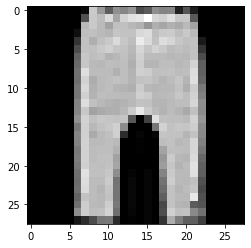

In [186]:
for image, cat in dataloader:
    plt.imshow(image[0].numpy().reshape(28, 28), cmap='gray')
    break

In [173]:
image.size()

torch.Size([64, 1, 28, 28])

In [174]:
28*28

784

### Create generator and discriminator

In [0]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential( 
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())
        
    def forward(self, x):
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1), 
            nn.Sigmoid())
    def forward(self, x):
        return self.model(x)

In [0]:
generator = Generator()
discriminator = Discriminator()

In [204]:
generator.cuda()
discriminator.cuda()

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=200, out_features=50, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

### Create optimizers and loss

In [0]:
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.BCELoss()

### Create necessary variables

In [0]:
input = Variable(torch.FloatTensor(config.batch_size, 28*28)).cuda()
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size)).cuda()
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size)).cuda()
real_label = 1
fake_label = 0

### Задание

1) Посмотрите на реализацию GAN. Постройте интерполяцию между какими-нибудь двумя сгенерированными картинками. (Опционально)Добавьте свертки в генератор и дискриминатор, как в статье про DCGAN.

2) Поменяйте ее, чтобы получился LSGAN https://arxiv.org/pdf/1611.04076v2.pdf

3) Добавьте к обучению GAN условие на метку, продемонстрируйте условную генерацию. https://arxiv.org/pdf/1411.1784.pdf

4) Напишите отчет что попробовали, какие результаты получили, как вам кажется надо обучать GAN, чтобы добиться сходимости?

В каждом пункте постройте графики функций потерь.

### GAN

In [0]:
def train(generator, discriminator, criterion):

    config.noise_size = 100
    config.batch_size = 64
    input = Variable(torch.FloatTensor(config.batch_size, 28*28)).cuda()
    noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size)).cuda()
    fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
    label = Variable(torch.FloatTensor(config.batch_size)).cuda()
    real_label = 1
    fake_label = 0
    
    optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
    optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)
    
    
    ERRD_x = np.zeros(config.num_epochs)
    ERRD_z = np.zeros(config.num_epochs)
    ERRG = np.zeros(config.num_epochs)
    N = len(dataloader)

    for epoch in range(config.num_epochs):
        for iteration, (images, cat) in enumerate(dataloader):
            ####### 
            # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
            #######
            images = images.cuda()
            if images.shape[0] != config.batch_size:
                continue
            #cat = cat.cuda()
            discriminator.zero_grad()

            # real
            label.data.fill_(real_label)
            #input_data = images.view(images.shape[0], -1)
            output = discriminator(images)
            errD_x = criterion(output, label.view(config.batch_size, 1))
            ERRD_x[epoch] += errD_x.item()
            errD_x.backward()

            # fake 
            noise.data.normal_(0, 1)
            fake = generator(noise)
            label.data.fill_(fake_label)
            output = discriminator(fake.detach())
            errD_z = criterion(output, label.view(config.batch_size, 1))
            ERRD_z[epoch] += errD_z.item()
            errD_z.backward()

            optim_D.step()

            ####### 
            # Generator stage: maximize log(D(G(x))
            #######
            generator.zero_grad()
            label.data.fill_(real_label)
            output = discriminator(fake)
            errG = criterion(output, label.view(config.batch_size, 1))
            ERRG[epoch] += errG.item()
            errG.backward()

            optim_G.step()

            if (iteration+1) % config.print_freq == 0:
                print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1, 
                                                                                            errD_x.item(),
                                                                                            errD_z.item(), 
                                                                                            errG.item()))
        z = Variable(torch.randn(9, 100)).cuda()
        sample_images = generator(z).unsqueeze(1).data.cpu()

        grid = make_grid(sample_images.view(9, 1, 28, 28), nrow=3, normalize=True).permute(1,2,0).numpy()
        plt.imshow(grid)
        plt.show()

    return ERRD_x, ERRD_z, ERRG

Epoch:1 Iter: 100 errD_x: 0.17 errD_z: 0.17 errG: 2.72
Epoch:1 Iter: 200 errD_x: 0.12 errD_z: 0.06 errG: 4.03
Epoch:1 Iter: 300 errD_x: 0.14 errD_z: 0.10 errG: 3.36
Epoch:1 Iter: 400 errD_x: 0.21 errD_z: 0.18 errG: 2.97
Epoch:1 Iter: 500 errD_x: 0.30 errD_z: 0.16 errG: 3.25
Epoch:1 Iter: 600 errD_x: 0.21 errD_z: 0.19 errG: 3.45
Epoch:1 Iter: 700 errD_x: 0.21 errD_z: 0.12 errG: 3.10
Epoch:1 Iter: 800 errD_x: 0.33 errD_z: 0.21 errG: 3.34
Epoch:1 Iter: 900 errD_x: 0.21 errD_z: 0.24 errG: 3.21


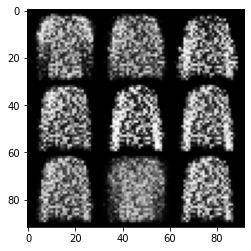

Epoch:2 Iter: 100 errD_x: 0.45 errD_z: 0.14 errG: 3.49
Epoch:2 Iter: 200 errD_x: 0.10 errD_z: 0.33 errG: 3.07
Epoch:2 Iter: 300 errD_x: 0.40 errD_z: 0.14 errG: 3.37
Epoch:2 Iter: 400 errD_x: 0.24 errD_z: 0.15 errG: 3.10
Epoch:2 Iter: 500 errD_x: 0.09 errD_z: 0.10 errG: 3.03
Epoch:2 Iter: 600 errD_x: 0.13 errD_z: 0.09 errG: 3.67
Epoch:2 Iter: 700 errD_x: 0.12 errD_z: 0.10 errG: 2.91
Epoch:2 Iter: 800 errD_x: 0.04 errD_z: 0.06 errG: 3.95
Epoch:2 Iter: 900 errD_x: 0.12 errD_z: 0.06 errG: 3.43


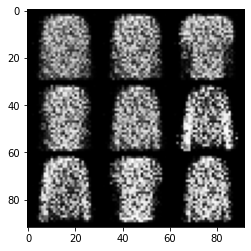

Epoch:3 Iter: 100 errD_x: 0.10 errD_z: 0.07 errG: 3.45
Epoch:3 Iter: 200 errD_x: 0.09 errD_z: 0.05 errG: 3.96
Epoch:3 Iter: 300 errD_x: 0.08 errD_z: 0.04 errG: 4.14
Epoch:3 Iter: 400 errD_x: 0.10 errD_z: 0.07 errG: 3.42
Epoch:3 Iter: 500 errD_x: 0.14 errD_z: 0.05 errG: 3.53
Epoch:3 Iter: 600 errD_x: 0.05 errD_z: 0.12 errG: 3.28
Epoch:3 Iter: 700 errD_x: 0.32 errD_z: 0.14 errG: 2.67
Epoch:3 Iter: 800 errD_x: 0.16 errD_z: 0.15 errG: 3.81
Epoch:3 Iter: 900 errD_x: 0.14 errD_z: 0.20 errG: 3.38


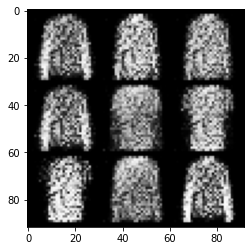

Epoch:4 Iter: 100 errD_x: 0.09 errD_z: 0.33 errG: 2.90
Epoch:4 Iter: 200 errD_x: 0.25 errD_z: 0.06 errG: 3.40
Epoch:4 Iter: 300 errD_x: 0.16 errD_z: 0.06 errG: 3.77
Epoch:4 Iter: 400 errD_x: 0.14 errD_z: 0.11 errG: 2.62
Epoch:4 Iter: 500 errD_x: 0.27 errD_z: 0.09 errG: 3.45
Epoch:4 Iter: 600 errD_x: 0.17 errD_z: 0.12 errG: 2.86
Epoch:4 Iter: 700 errD_x: 0.38 errD_z: 0.06 errG: 3.73
Epoch:4 Iter: 800 errD_x: 0.22 errD_z: 0.08 errG: 3.67
Epoch:4 Iter: 900 errD_x: 0.19 errD_z: 0.11 errG: 2.89


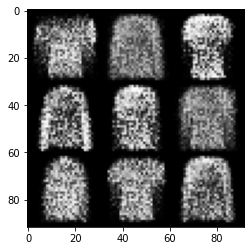

Epoch:5 Iter: 100 errD_x: 0.06 errD_z: 0.09 errG: 3.76
Epoch:5 Iter: 200 errD_x: 0.09 errD_z: 0.05 errG: 3.45
Epoch:5 Iter: 300 errD_x: 0.23 errD_z: 0.05 errG: 4.36
Epoch:5 Iter: 400 errD_x: 0.16 errD_z: 0.05 errG: 3.84
Epoch:5 Iter: 500 errD_x: 0.26 errD_z: 0.04 errG: 2.99
Epoch:5 Iter: 600 errD_x: 0.17 errD_z: 0.10 errG: 3.75
Epoch:5 Iter: 700 errD_x: 0.21 errD_z: 0.14 errG: 2.99
Epoch:5 Iter: 800 errD_x: 0.17 errD_z: 0.21 errG: 2.57
Epoch:5 Iter: 900 errD_x: 0.24 errD_z: 0.17 errG: 2.95


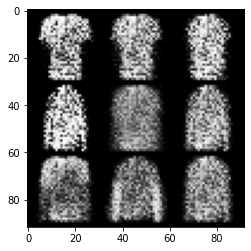

Epoch:6 Iter: 100 errD_x: 0.21 errD_z: 0.09 errG: 3.08
Epoch:6 Iter: 200 errD_x: 0.19 errD_z: 0.10 errG: 3.35
Epoch:6 Iter: 300 errD_x: 0.17 errD_z: 0.09 errG: 2.94
Epoch:6 Iter: 400 errD_x: 0.25 errD_z: 0.03 errG: 4.48
Epoch:6 Iter: 500 errD_x: 0.05 errD_z: 0.14 errG: 3.39
Epoch:6 Iter: 600 errD_x: 0.33 errD_z: 0.05 errG: 3.96
Epoch:6 Iter: 700 errD_x: 0.16 errD_z: 0.11 errG: 3.60
Epoch:6 Iter: 800 errD_x: 0.10 errD_z: 0.06 errG: 3.52
Epoch:6 Iter: 900 errD_x: 0.10 errD_z: 0.17 errG: 3.18


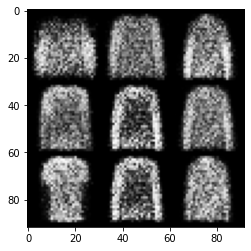

Epoch:7 Iter: 100 errD_x: 0.42 errD_z: 0.15 errG: 2.45
Epoch:7 Iter: 200 errD_x: 0.27 errD_z: 0.40 errG: 2.34
Epoch:7 Iter: 300 errD_x: 0.22 errD_z: 0.14 errG: 2.88
Epoch:7 Iter: 400 errD_x: 0.21 errD_z: 0.15 errG: 2.75
Epoch:7 Iter: 500 errD_x: 0.27 errD_z: 0.12 errG: 2.86
Epoch:7 Iter: 600 errD_x: 0.26 errD_z: 0.28 errG: 2.98
Epoch:7 Iter: 700 errD_x: 0.38 errD_z: 0.14 errG: 3.13
Epoch:7 Iter: 800 errD_x: 0.40 errD_z: 0.16 errG: 2.80
Epoch:7 Iter: 900 errD_x: 0.27 errD_z: 0.18 errG: 3.08


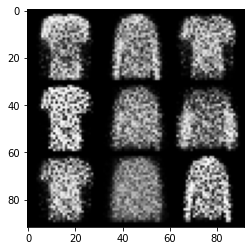

Epoch:8 Iter: 100 errD_x: 0.19 errD_z: 0.08 errG: 3.53
Epoch:8 Iter: 200 errD_x: 0.50 errD_z: 0.13 errG: 2.56
Epoch:8 Iter: 300 errD_x: 0.14 errD_z: 0.27 errG: 3.00
Epoch:8 Iter: 400 errD_x: 0.10 errD_z: 0.12 errG: 3.03
Epoch:8 Iter: 500 errD_x: 0.10 errD_z: 0.11 errG: 3.14
Epoch:8 Iter: 600 errD_x: 0.26 errD_z: 0.08 errG: 2.93
Epoch:8 Iter: 700 errD_x: 0.12 errD_z: 0.08 errG: 3.18
Epoch:8 Iter: 800 errD_x: 0.22 errD_z: 0.12 errG: 2.94
Epoch:8 Iter: 900 errD_x: 0.15 errD_z: 0.10 errG: 2.57


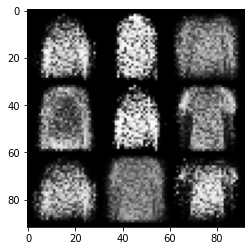

Epoch:9 Iter: 100 errD_x: 0.37 errD_z: 0.25 errG: 2.22
Epoch:9 Iter: 200 errD_x: 0.32 errD_z: 0.26 errG: 2.03
Epoch:9 Iter: 300 errD_x: 0.21 errD_z: 0.21 errG: 2.78
Epoch:9 Iter: 400 errD_x: 0.23 errD_z: 0.29 errG: 1.92
Epoch:9 Iter: 500 errD_x: 0.13 errD_z: 0.22 errG: 2.92
Epoch:9 Iter: 600 errD_x: 0.30 errD_z: 0.08 errG: 3.62
Epoch:9 Iter: 700 errD_x: 0.15 errD_z: 0.29 errG: 2.64
Epoch:9 Iter: 800 errD_x: 0.09 errD_z: 0.08 errG: 3.74
Epoch:9 Iter: 900 errD_x: 0.21 errD_z: 0.09 errG: 3.17


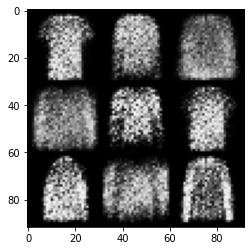

Epoch:10 Iter: 100 errD_x: 0.06 errD_z: 0.14 errG: 3.25
Epoch:10 Iter: 200 errD_x: 0.30 errD_z: 0.06 errG: 3.60
Epoch:10 Iter: 300 errD_x: 0.15 errD_z: 0.15 errG: 2.84
Epoch:10 Iter: 400 errD_x: 0.13 errD_z: 0.03 errG: 4.25
Epoch:10 Iter: 500 errD_x: 0.52 errD_z: 0.06 errG: 3.55
Epoch:10 Iter: 600 errD_x: 0.10 errD_z: 0.04 errG: 4.40
Epoch:10 Iter: 700 errD_x: 0.35 errD_z: 0.22 errG: 2.44
Epoch:10 Iter: 800 errD_x: 0.11 errD_z: 0.07 errG: 3.48
Epoch:10 Iter: 900 errD_x: 0.25 errD_z: 0.23 errG: 2.47


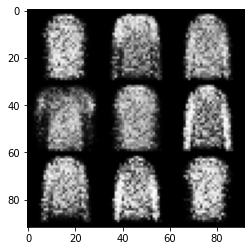

(array([225.7569083 , 176.64692185, 128.76586871, 163.11194211,
        185.57147699, 156.8404711 , 282.50956806, 190.9632384 ,
        261.26675647, 223.42039084]),
 array([141.4508228 , 103.66077226,  83.96002112, 104.62308137,
        122.37182786, 108.00301195, 177.1612282 , 122.256041  ,
        162.50056925, 139.23598659]),
 array([3021.7361629 , 3257.43011642, 3282.99320328, 3107.22458029,
        3064.28573573, 3026.03995097, 2658.91220677, 2822.48401797,
        2567.56925297, 2683.17247188]))

In [222]:
criterion = nn.BCELoss()
train(generator, discriminator, criterion)

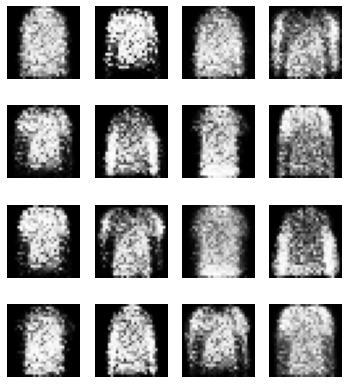

In [223]:
def make_samples(generator):
    noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size)).cuda()
    noise.data.normal_(0, 1)
    fake = generator(noise)

    plt.figure(figsize=(6, 7))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(fake[i].cpu().detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
        plt.axis('off')
make_samples(generator)

## Задание 1

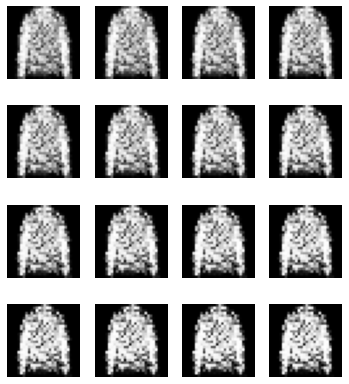

In [224]:
# Интерполяция между двумя сгенерированными картинками
noise1 = Variable(torch.FloatTensor(config.batch_size, config.noise_size)).cuda()
noise1.data.normal_(0, 1)
noise2 = Variable(torch.FloatTensor(config.batch_size, config.noise_size)).cuda()
noise2.data.normal_(0, 1)
diff = noise1 - noise2

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    fake = generator(noise1 + (i/15)*diff)
    imag1 = fake[0].cpu().detach().numpy().reshape(28, 28)
    plt.imshow(imag1, cmap=plt.cm.Greys_r)
    plt.axis('off')

In [0]:
class DCGenerator(nn.Module):
    def __init__(self, channels=1):
        super(DCGenerator, self).__init__()

        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 64 * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 2 x 2
            nn.ConvTranspose2d(64 * 8, 64 * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 4 x 4
            nn.ConvTranspose2d(64 * 4, 64 * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 8 x 8
            nn.ConvTranspose2d(64 * 2, 64, kernel_size=2, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # state size. (ngf) x 14 x 14
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # state size. (nc) x 28 x 28
        )

    def forward(self, inputs):
        inputs = inputs.view(-1, 100, 1, 1)
        outputs = self.main(inputs)
        return outputs
    
class DCDiscriminator(nn.Module):
    def __init__(self):
        super(DCDiscriminator, self).__init__()
        self.main = nn.Sequential(
            # inputs is (nc) x 28 x 28
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 14 x 14
            nn.Conv2d(64, 64 * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 7 x 7
            nn.Conv2d(64 * 2, 64 * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 3 x 3
            nn.Conv2d(64 * 4, 64 * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 1 x 1
            nn.Conv2d(64 * 8, 1, kernel_size=1, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, inputs):
        inputs = inputs.view(-1, 1, 28, 28)
        outputs = self.main(inputs)
        return outputs.view(-1, 1)

Epoch:1 Iter: 100 errD_x: 0.54 errD_z: 0.54 errG: 0.90
Epoch:1 Iter: 200 errD_x: 0.47 errD_z: 0.43 errG: 1.10
Epoch:1 Iter: 300 errD_x: 0.47 errD_z: 0.36 errG: 1.26
Epoch:1 Iter: 400 errD_x: 0.24 errD_z: 0.29 errG: 1.45
Epoch:1 Iter: 500 errD_x: 0.21 errD_z: 0.24 errG: 1.63
Epoch:1 Iter: 600 errD_x: 0.25 errD_z: 0.20 errG: 1.79
Epoch:1 Iter: 700 errD_x: 0.19 errD_z: 0.18 errG: 1.95
Epoch:1 Iter: 800 errD_x: 0.56 errD_z: 0.16 errG: 2.00
Epoch:1 Iter: 900 errD_x: 0.26 errD_z: 0.16 errG: 2.09


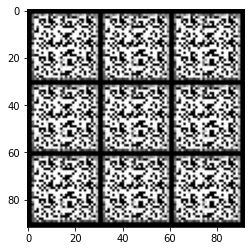

Epoch:2 Iter: 100 errD_x: 0.19 errD_z: 0.14 errG: 2.20
Epoch:2 Iter: 200 errD_x: 0.12 errD_z: 0.14 errG: 2.45
Epoch:2 Iter: 300 errD_x: 0.05 errD_z: 0.16 errG: 2.47
Epoch:2 Iter: 400 errD_x: 0.11 errD_z: 0.25 errG: 1.67
Epoch:2 Iter: 500 errD_x: 0.13 errD_z: 0.29 errG: 1.40
Epoch:2 Iter: 600 errD_x: 0.04 errD_z: 0.21 errG: 1.67
Epoch:2 Iter: 700 errD_x: 0.04 errD_z: 0.16 errG: 1.94
Epoch:2 Iter: 800 errD_x: 0.03 errD_z: 0.12 errG: 2.17
Epoch:2 Iter: 900 errD_x: 0.02 errD_z: 0.10 errG: 2.37


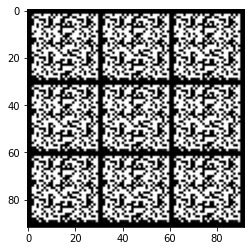

Epoch:3 Iter: 100 errD_x: 0.02 errD_z: 0.08 errG: 2.63
Epoch:3 Iter: 200 errD_x: 0.02 errD_z: 0.07 errG: 2.75
Epoch:3 Iter: 300 errD_x: 0.01 errD_z: 0.05 errG: 2.94
Epoch:3 Iter: 400 errD_x: 0.02 errD_z: 0.05 errG: 3.09
Epoch:3 Iter: 500 errD_x: 0.01 errD_z: 0.04 errG: 3.25
Epoch:3 Iter: 600 errD_x: 0.01 errD_z: 0.04 errG: 3.37
Epoch:3 Iter: 700 errD_x: 0.01 errD_z: 0.03 errG: 3.50
Epoch:3 Iter: 800 errD_x: 0.03 errD_z: 0.03 errG: 3.60
Epoch:3 Iter: 900 errD_x: 0.01 errD_z: 0.02 errG: 3.71


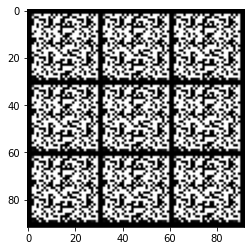

Epoch:4 Iter: 100 errD_x: 0.00 errD_z: 0.02 errG: 3.87
Epoch:4 Iter: 200 errD_x: 0.01 errD_z: 0.02 errG: 4.05
Epoch:4 Iter: 300 errD_x: 0.05 errD_z: 0.28 errG: 3.07
Epoch:4 Iter: 400 errD_x: 0.05 errD_z: 0.05 errG: 3.24
Epoch:4 Iter: 500 errD_x: 0.08 errD_z: 0.05 errG: 3.35
Epoch:4 Iter: 600 errD_x: 0.06 errD_z: 0.05 errG: 3.39
Epoch:4 Iter: 700 errD_x: 0.12 errD_z: 0.08 errG: 3.28
Epoch:4 Iter: 800 errD_x: 0.03 errD_z: 0.04 errG: 3.60
Epoch:4 Iter: 900 errD_x: 0.02 errD_z: 0.03 errG: 3.71


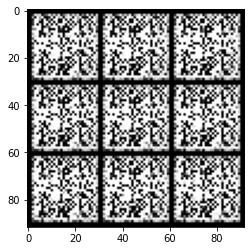

Epoch:5 Iter: 100 errD_x: 0.04 errD_z: 0.04 errG: 3.57
Epoch:5 Iter: 200 errD_x: 0.02 errD_z: 0.03 errG: 3.76
Epoch:5 Iter: 300 errD_x: 0.07 errD_z: 0.04 errG: 3.96
Epoch:5 Iter: 400 errD_x: 0.05 errD_z: 0.04 errG: 3.83
Epoch:5 Iter: 500 errD_x: 0.03 errD_z: 0.04 errG: 3.97
Epoch:5 Iter: 600 errD_x: 0.04 errD_z: 0.12 errG: 4.45
Epoch:5 Iter: 700 errD_x: 0.04 errD_z: 0.03 errG: 4.06
Epoch:5 Iter: 800 errD_x: 0.02 errD_z: 0.02 errG: 4.34
Epoch:5 Iter: 900 errD_x: 0.06 errD_z: 0.02 errG: 4.31


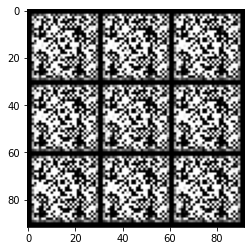

Epoch:6 Iter: 100 errD_x: 0.02 errD_z: 0.02 errG: 4.20
Epoch:6 Iter: 200 errD_x: 0.05 errD_z: 0.02 errG: 4.46
Epoch:6 Iter: 300 errD_x: 0.02 errD_z: 0.02 errG: 4.23
Epoch:6 Iter: 400 errD_x: 0.02 errD_z: 0.01 errG: 4.66
Epoch:6 Iter: 500 errD_x: 0.01 errD_z: 0.02 errG: 4.07
Epoch:6 Iter: 600 errD_x: 0.01 errD_z: 0.02 errG: 4.26
Epoch:6 Iter: 700 errD_x: 0.01 errD_z: 0.02 errG: 4.47
Epoch:6 Iter: 800 errD_x: 0.02 errD_z: 0.02 errG: 4.22
Epoch:6 Iter: 900 errD_x: 0.01 errD_z: 0.01 errG: 4.60


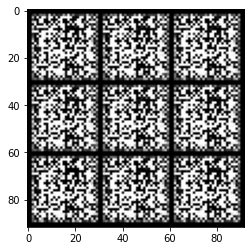

Epoch:7 Iter: 100 errD_x: 0.01 errD_z: 0.02 errG: 4.66
Epoch:7 Iter: 200 errD_x: 0.01 errD_z: 0.02 errG: 4.68
Epoch:7 Iter: 300 errD_x: 0.06 errD_z: 0.02 errG: 4.56
Epoch:7 Iter: 400 errD_x: 0.03 errD_z: 0.02 errG: 4.39
Epoch:7 Iter: 500 errD_x: 0.03 errD_z: 0.02 errG: 4.46
Epoch:7 Iter: 600 errD_x: 0.01 errD_z: 0.01 errG: 5.02
Epoch:7 Iter: 700 errD_x: 0.03 errD_z: 0.02 errG: 4.73
Epoch:7 Iter: 800 errD_x: 0.01 errD_z: 0.01 errG: 4.73
Epoch:7 Iter: 900 errD_x: 0.03 errD_z: 0.02 errG: 5.27


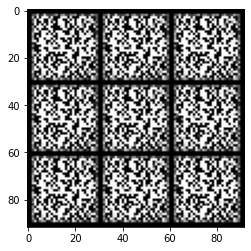

Epoch:8 Iter: 100 errD_x: 0.04 errD_z: 0.01 errG: 5.26
Epoch:8 Iter: 200 errD_x: 0.00 errD_z: 0.01 errG: 4.83
Epoch:8 Iter: 300 errD_x: 0.01 errD_z: 0.01 errG: 5.16
Epoch:8 Iter: 400 errD_x: 0.02 errD_z: 0.01 errG: 5.00
Epoch:8 Iter: 500 errD_x: 0.01 errD_z: 0.01 errG: 5.25
Epoch:8 Iter: 600 errD_x: 0.00 errD_z: 0.02 errG: 4.30
Epoch:8 Iter: 700 errD_x: 0.02 errD_z: 0.01 errG: 4.77
Epoch:8 Iter: 800 errD_x: 0.01 errD_z: 0.01 errG: 5.32
Epoch:8 Iter: 900 errD_x: 0.01 errD_z: 0.03 errG: 4.84


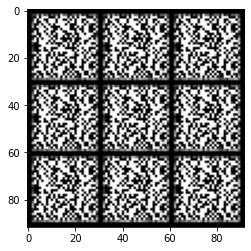

Epoch:9 Iter: 100 errD_x: 0.03 errD_z: 0.01 errG: 5.27
Epoch:9 Iter: 200 errD_x: 0.01 errD_z: 0.01 errG: 5.08
Epoch:9 Iter: 300 errD_x: 0.00 errD_z: 0.01 errG: 5.13
Epoch:9 Iter: 400 errD_x: 0.01 errD_z: 0.01 errG: 5.53
Epoch:9 Iter: 500 errD_x: 0.00 errD_z: 0.01 errG: 5.05
Epoch:9 Iter: 600 errD_x: 0.02 errD_z: 0.01 errG: 5.41
Epoch:9 Iter: 700 errD_x: 0.00 errD_z: 0.03 errG: 4.91
Epoch:9 Iter: 800 errD_x: 0.00 errD_z: 0.01 errG: 4.67
Epoch:9 Iter: 900 errD_x: 0.00 errD_z: 0.01 errG: 5.28


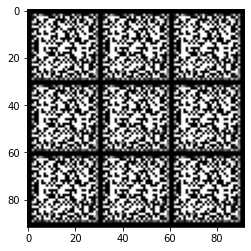

Epoch:10 Iter: 100 errD_x: 0.01 errD_z: 0.01 errG: 5.98
Epoch:10 Iter: 200 errD_x: 0.01 errD_z: 0.18 errG: 6.73
Epoch:10 Iter: 300 errD_x: 0.00 errD_z: 0.01 errG: 5.14
Epoch:10 Iter: 400 errD_x: 0.01 errD_z: 0.01 errG: 5.68
Epoch:10 Iter: 500 errD_x: 0.00 errD_z: 0.01 errG: 5.07
Epoch:10 Iter: 600 errD_x: 0.01 errD_z: 0.01 errG: 5.34
Epoch:10 Iter: 700 errD_x: 0.02 errD_z: 0.01 errG: 5.99
Epoch:10 Iter: 800 errD_x: 0.00 errD_z: 0.01 errG: 5.28
Epoch:10 Iter: 900 errD_x: 0.00 errD_z: 0.01 errG: 5.47


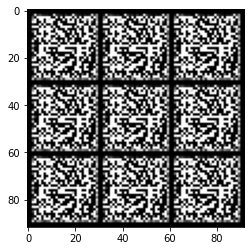

(array([290.61942033,  76.13003286,  12.67515986,  41.98312394,
         36.23165178,  24.97960398,  19.12794165,  21.0715122 ,
         14.56181833,  10.71188324]),
 array([289.964269  , 161.99432886,  44.14202605,  51.87552031,
         33.24272063,  22.38505616,  18.51209325,  18.50319383,
         15.81333289,  12.14713972]),
 array([1426.37718666, 1911.2495141 , 2966.90594006, 3374.67999458,
        3720.52671862, 4046.17299438, 4472.78406858, 4644.18149614,
        4902.30566263, 5202.58836699]))

In [238]:
generator = DCGenerator().cuda()
discriminator = DCDiscriminator().cuda()
criterion = nn.BCELoss()
train(generator, discriminator, criterion)

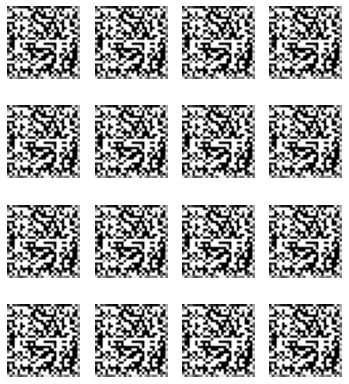

In [239]:
make_samples(generator)

## Задание 2

In [0]:
config.noise_size = 1024
false_label = 0.00001
class LSGenerator(nn.Module):
    def __init__(self):
        super(LSGenerator, self).__init__()
        self.model = nn.Sequential( 
            nn.ConvTranspose2d(100, 256, kernel_size=2, stride=2, padding=0),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 256, kernel_size=6, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 128, kernel_size=6, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = x.view(-1, 100, 1, 1)
        x = self.model(x)
        return x
    
class LSDiscriminator(nn.Module):
    def __init__(self):
        super(LSDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(512),
        )
        self.last_linear = nn.Sequential(nn.Linear(2*2*512, 1), nn.Sigmoid())
    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.model(x)
        x = x.view(-1, 2*2*512)
        return self.last_linear(x)

In [160]:
false_label = 0.00001 # обучается очень долго, поэтому оставим 4 эпохи
generator = LSGenerator().cuda()
discriminator = LSDiscriminator().cuda()
loss = nn.MSELoss()
train(generator, discriminator, loss)

Epoch:1 Iter: 100 errD_x: 0.00 errD_z: 0.00 errG: 1.00
Epoch:1 Iter: 200 errD_x: 0.00 errD_z: 0.00 errG: 1.00
Epoch:1 Iter: 300 errD_x: 0.00 errD_z: 0.00 errG: 1.00
Epoch:1 Iter: 400 errD_x: 0.00 errD_z: 0.00 errG: 1.00


KeyboardInterrupt: ignored

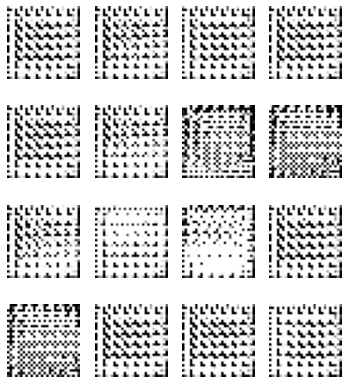

In [0]:
make_samples(generator)

## Задание 3.

In [0]:
transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
dataset = torchvision.datasets.FashionMNIST("fashion_mnist", train=True, transform=transform, download=True)
data_loader = DataLoader(train, batch_size=64, shuffle=True)

In [0]:
class CGANDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        x = x.view(x.size(0), 784)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.squeeze()

class CGANGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(x.size(0), 28, 28)

In [0]:
generator = CGANGenerator().cuda()
discriminator = CGANDiscriminator().cuda()

In [0]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)

In [0]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).cuda())
    g_loss.backward()
    g_optimizer.step()
    return g_loss.item()

In [0]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    # train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).cuda())
    
    # train with fake images
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).cuda())
    
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.item()

Starting epoch 0...
g_loss: 1.9382643699645996, d_loss: 0.3481026589870453


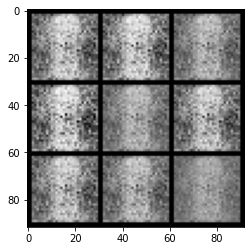

Starting epoch 1...
g_loss: 1.9669241905212402, d_loss: 1.1372116804122925


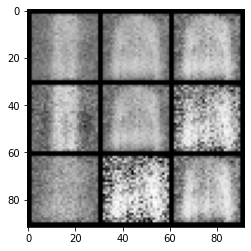

Starting epoch 2...
g_loss: 2.2321696281433105, d_loss: 0.5090981125831604


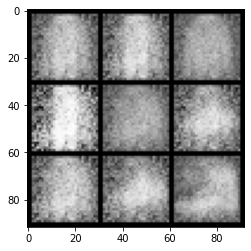

Starting epoch 3...
g_loss: 1.551106572151184, d_loss: 0.7400264739990234


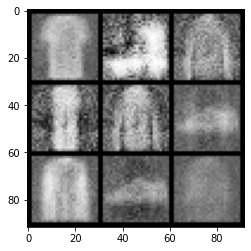

Starting epoch 4...
g_loss: 1.8461472988128662, d_loss: 0.7402089834213257


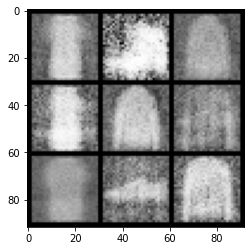

Starting epoch 5...
g_loss: 1.4282469749450684, d_loss: 0.890588641166687


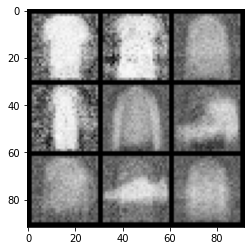

Starting epoch 6...
g_loss: 1.53885817527771, d_loss: 0.8991056084632874


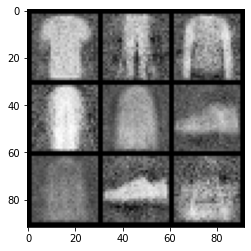

Starting epoch 7...
g_loss: 1.512332797050476, d_loss: 1.0896987915039062


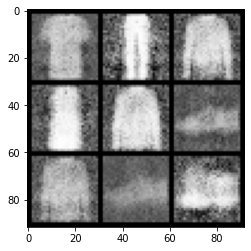

Starting epoch 8...
g_loss: 1.2288086414337158, d_loss: 0.9217658638954163


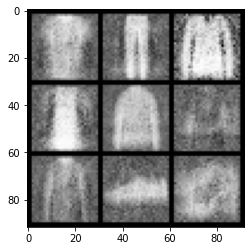

Starting epoch 9...
g_loss: 1.1683233976364136, d_loss: 1.242112636566162


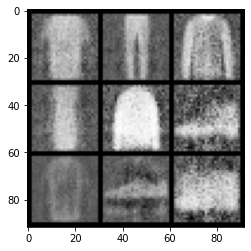

Starting epoch 10...
g_loss: 1.0910694599151611, d_loss: 0.9117250442504883


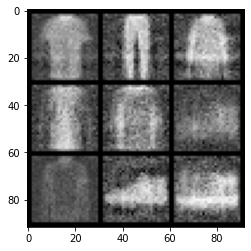

Starting epoch 11...
g_loss: 1.1227712631225586, d_loss: 0.9443978071212769


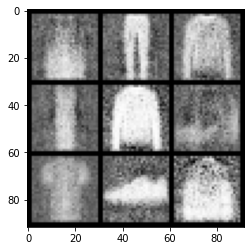

Starting epoch 12...
g_loss: 1.4121415615081787, d_loss: 0.9642820954322815


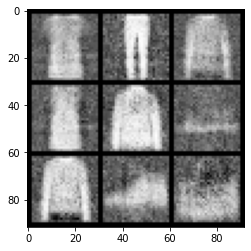

Starting epoch 13...
g_loss: 1.2633321285247803, d_loss: 0.9434828162193298


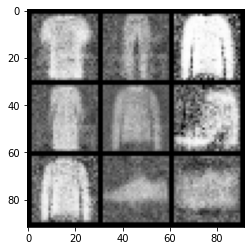

Starting epoch 14...
g_loss: 1.4643409252166748, d_loss: 0.8841972351074219


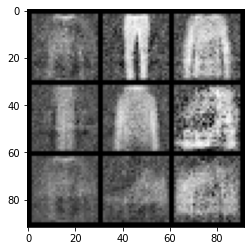

Starting epoch 15...
g_loss: 1.4520169496536255, d_loss: 0.7131481170654297


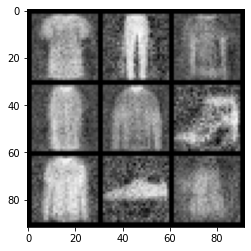

Starting epoch 16...
g_loss: 1.193514108657837, d_loss: 1.2808024883270264


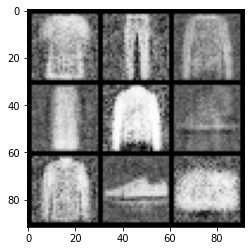

Starting epoch 17...
g_loss: 1.1732280254364014, d_loss: 1.0182664394378662


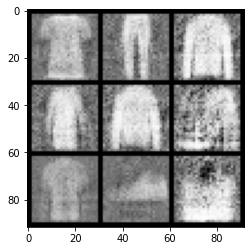

Starting epoch 18...
g_loss: 1.3627257347106934, d_loss: 1.060838222503662


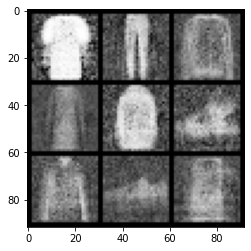

Starting epoch 19...
g_loss: 1.5112977027893066, d_loss: 0.8788855075836182


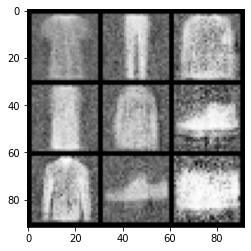

Starting epoch 20...
g_loss: 1.1631758213043213, d_loss: 0.9763258695602417


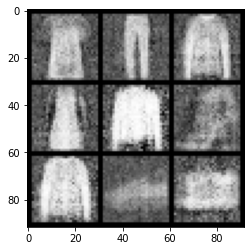

Starting epoch 21...
g_loss: 1.4851326942443848, d_loss: 1.1425347328186035


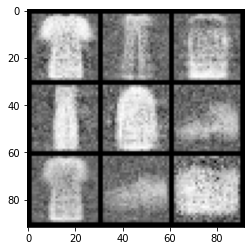

Starting epoch 22...
g_loss: 1.6744444370269775, d_loss: 0.6809342503547668


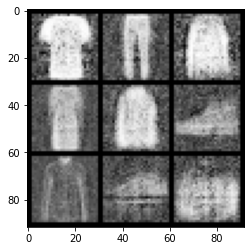

Starting epoch 23...
g_loss: 1.235656499862671, d_loss: 0.9041292667388916


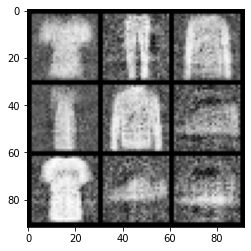

Starting epoch 24...
g_loss: 1.357062816619873, d_loss: 0.865165114402771


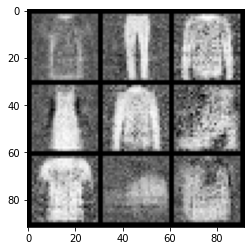

Starting epoch 25...
g_loss: 1.392447829246521, d_loss: 0.7232887744903564


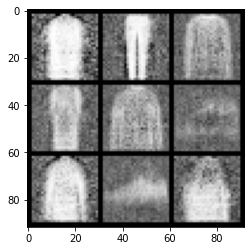

Starting epoch 26...
g_loss: 1.2771308422088623, d_loss: 1.01051926612854


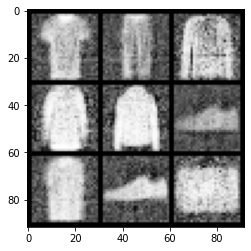

Starting epoch 27...
g_loss: 1.0636842250823975, d_loss: 1.176259994506836


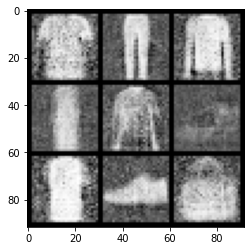

Starting epoch 28...
g_loss: 1.6073888540267944, d_loss: 0.7118319869041443


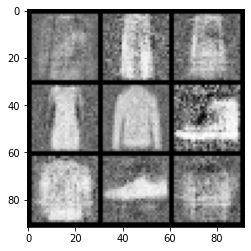

Starting epoch 29...
g_loss: 1.3565455675125122, d_loss: 1.0011358261108398


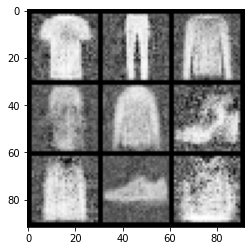

In [131]:
num_epochs = 30
n_critic = 5
display_step = 300
for epoch in range(num_epochs):
    print('Starting epoch {}...'.format(epoch))
    for i, (images, labels) in enumerate(data_loader):
        real_images = Variable(images).cuda()
        labels = Variable(labels).cuda()
        generator.train()
        batch_size = real_images.size(0)
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)
        

        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)

    generator.eval()
    print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))
    z = Variable(torch.randn(9, 100)).cuda()
    labels = Variable(torch.LongTensor(np.arange(9))).cuda()
    sample_images = generator(z, labels).unsqueeze(1).data.cpu()
    grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()

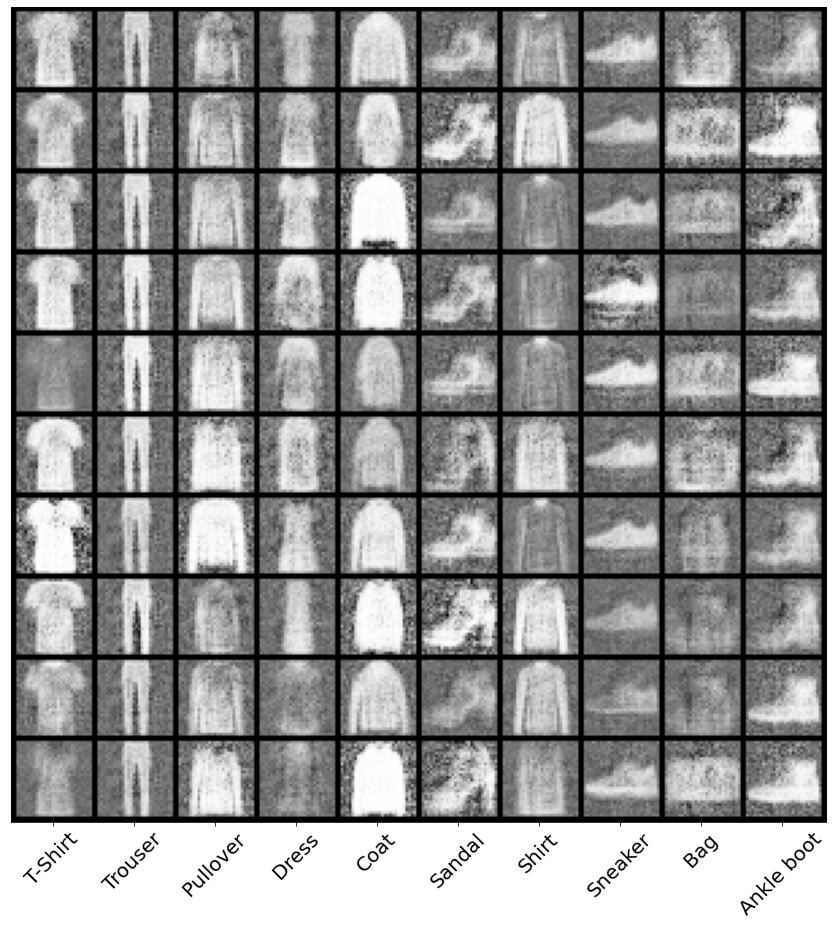

In [132]:
z = Variable(torch.randn(100, 100)).cuda()
labels = Variable(torch.LongTensor([i for _ in range(10) for i in range(10)])).cuda()
sample_images = generator(z, labels).unsqueeze(1).data.cpu()
grid = make_grid(sample_images, nrow=10, normalize=True).permute(1,2,0).numpy()
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(grid)
_ = plt.yticks([])
_ = plt.xticks(np.arange(15, 300, 30), ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], rotation=45, fontsize=20)

Почему-то GAN со свертками не очень справились с задачей. Такое ощущение, что сети не обучаются вообще и играют в какую-то странную угадайку между собой вообще не смотря на данные. https://github.com/Lornatang/DCGAN-PyTorch/ работает почему-то тоже плохо.

Нормально работающий CGAN получилось сделать только без сверточных слоёв.